In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
import pandas as pd
import networkx as nx
import wntr
import zarr

import torch
from torch_geometric.utils import to_networkx

from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc


/home/andres/Dropbox/PhD Smart Environments - RUG/ExternalProjects/DiTEC_Vitens/ditecenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# PATH = "/home/andres/Dropbox/PhD Smart Environments - RUG/ExternalProjects/DiTEC_Vitens/signal-recovery/training"
PATH = "/home/andres/Dropbox/PhD Smart Environments - RUG/ExternalProjects/DiTEC_Vitens/signal-recovery/experiments_logs/simple_test"
MODEL = "GATRes"
VARIANT = "10k_1200_500_ElvtnCluster_noCoord" 
MASK_RATE = 0.95
ACC_THRESHOLD = 0.2

### Load results

In [3]:
training_loss_error = pickle.load(open(f"{PATH}/training_logs_{MODEL}_{VARIANT}.pkl", 'rb'))
train_errors = training_loss_error["train_error"]
train_losses = training_loss_error["train_loss"]
train_acc = training_loss_error["train_acc"]
val_errors = training_loss_error["val_error"]
val_losses = training_loss_error["val_loss"]
val_acc = training_loss_error["val_acc"]

In [4]:
np.std(train_losses), np.std(val_losses), np.mean(val_acc)

(0.0329083041121068, 0.01661967131343322, 0.8209505873179436)

In [5]:
# dirs = {
#     "best_training_model": f"../checkpoints/{MODEL}_best_training_{VARIANT}.pth",
# }

dirs = {
    "best_training_model": f"/home/andres/Dropbox/PhD Smart Environments - RUG/ExternalProjects/DiTEC_Vitens/signal-recovery/experiments_logs/simple_test/best_{MODEL}_{VARIANT}.pth",
}


checkpoint = torch.load(dirs["best_training_model"], map_location="cpu")
print(f"best epoch:{checkpoint['epoch'] - 1}")

best epoch:37


In [6]:
EPOCHS = len(train_losses)

### Plot training and validation accuracies and losses

In [7]:
best_epoch = checkpoint["epoch"] - 1
best_loss = val_losses[best_epoch]
best_error = val_errors[best_epoch]
best_acc = val_acc[best_epoch]
print(f"best_epoch:{best_epoch}", f"loss:{best_loss:.4f}, relative_error:{best_error:.4f}")

best_epoch:37 loss:0.2524, relative_error:0.1530


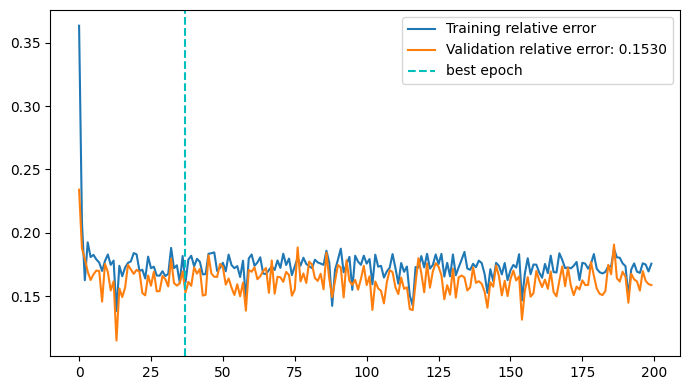

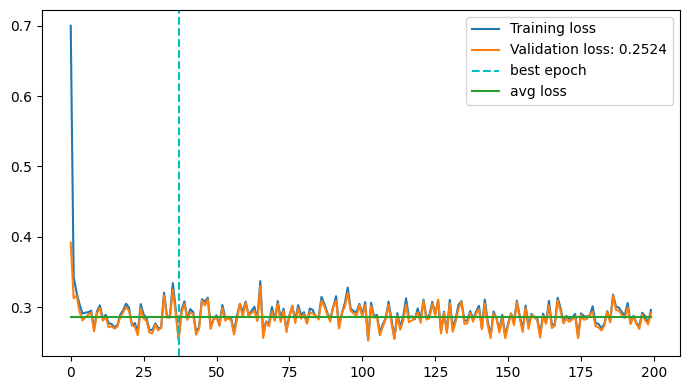

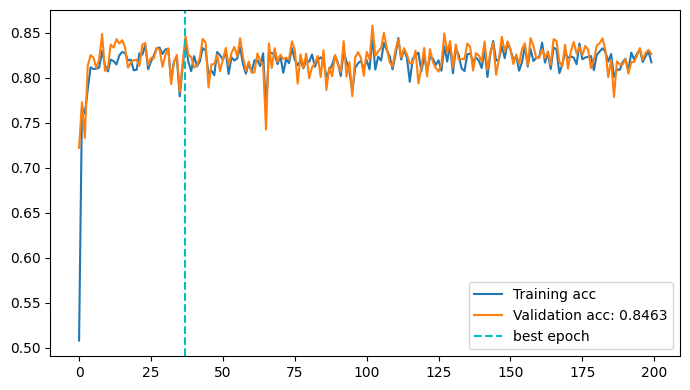

In [8]:
plt.figure(figsize=(7,4))
plt.plot(np.arange(EPOCHS), np.array(train_errors[0:EPOCHS]), label='Training relative error')
plt.plot(np.arange(EPOCHS), np.array(val_errors[0:EPOCHS]), label=f"Validation relative error: {best_error:.4f}")
plt.axvline(x = best_epoch, color = 'c', linestyle='dashed', label = 'best epoch')
# plt.plot(np.arange(EPOCHS), np.full((EPOCHS), fill_value=0.5), label="0.3 baseline")

plt.legend()

plt.tight_layout()
plt.savefig(f'{PATH}/figs/relative_error_{MODEL}_{VARIANT}.svg', format="svg"),
plt.show()

plt.figure(figsize=(7,4))
plt.plot(np.arange(EPOCHS), np.array(train_losses[0:EPOCHS]), label='Training loss')
plt.plot(np.arange(EPOCHS), np.array(val_losses[0:EPOCHS]), label=f"Validation loss: {best_loss:.4f}")
plt.axvline(x = best_epoch, color = 'c', linestyle='dashed', label = 'best epoch')
plt.plot(np.arange(EPOCHS), np.full((EPOCHS), fill_value=np.mean(val_losses)), label="avg loss")

plt.legend()
plt.tight_layout()
plt.savefig(f'{PATH}/figs/losses_{MODEL}_{VARIANT}.svg', format="svg"),
plt.show()


plt.figure(figsize=(7,4))

plt.plot(np.arange(EPOCHS), np.array(train_acc[0:EPOCHS]), label='Training acc')
plt.plot(np.arange(EPOCHS), np.array(val_acc[0:EPOCHS]), label=f"Validation acc: {best_acc:.4f}")
plt.axvline(x = best_epoch, color = 'c', linestyle='dashed', label = 'best epoch')
# plt.plot(np.arange(EPOCHS), np.full((EPOCHS), fill_value=np.mean(val_acc)), label="avg acc")

plt.legend()
plt.tight_layout()
plt.savefig(f'{PATH}/figs/accuracies_{MODEL}_{VARIANT}.svg', format="svg"),
plt.show()


### Correlation between graphs' nodes pressure values

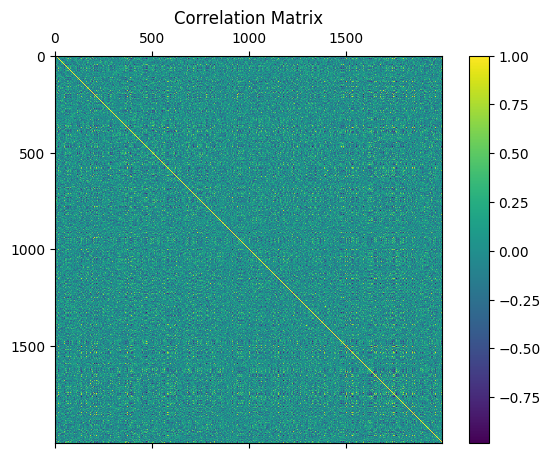

In [204]:
# path = "/home/andres/Dropbox/PhD Smart Environments - RUG/ExternalProjects/DiTEC_Vitens/signal-recovery/train_original_uncorr.pkl"
# train_data = pickle.load(open(f"{path}", 'rb'))

root = zarr.open(store="../../datasets/10k_p_EPYNET_s_GEN-09 Oosterbeek_20230119.zip", mode='r')
# root = zarr.open(store="../../datasets/5k_fpv_EPYNET_GEN-09 Oosterbeek_20221216.zip", mode='r')

train = np.asarray(root.pressure.train)
valid = np.asarray(root.pressure.valid)
data = valid #np.concatenate((train, valid))

corr = np.corrcoef(data)
mean_corr_scenario = np.mean(corr, axis=1)

fig = plt.figure(figsize=(7, 5))
plt.matshow(corr, fig)
cb = plt.colorbar()
plt.title('Correlation Matrix', fontsize=12)
# plt.savefig(f'../experiments_logs/figs/corr_mtrx_Oosterbeek_20221212.png', format="png"),
plt.show()

### Graph Visualization

In [84]:
# path_viz = (f"/home/andres/Dropbox/PhD Smart Environments - RUG/ExternalProjects/DiTEC_Vitens/signal-recovery/error_maps/")
# errors_file = f"rel_errors_per_node_{MODEL}_{VARIANT}_{MASK_RATE}.pkl"
# acc_file = f"acc_per_node_{MODEL}_{VARIANT}_{MASK_RATE}_{int(ACC_THRESHOLD*100)}_acc.pkl"

path_viz = (f"/home/andres/Dropbox/PhD Smart Environments - RUG/ExternalProjects/DiTEC_Vitens/signal-recovery/experiments_logs/simple_test/")
errors_file = f"rel_errors_{MODEL}_{VARIANT}.pkl"
acc_file = f"accuracies_{MODEL}_{VARIANT}.pkl"


relative_error = pickle.load(open(path_viz + errors_file, 'rb'))
relative_error[np.where(relative_error == np.min(relative_error))[0]] = 0

accuracy = pickle.load(open(path_viz + acc_file, 'rb'))
accuracy_per_scenario = np.mean(accuracy, axis=1)
accuracy_per_node = np.mean(accuracy, axis=0)

In [85]:
print(f"Errors - min: {relative_error.min()}, max: {relative_error.max()}, mean: {relative_error.mean()}")
print(f"mean accuracy: {np.mean(accuracy)}")

Errors - min: 0.0, max: 1.0, mean: 0.12067397683858871
mean accuracy: 0.8332486748695374


### Histogram of relative error

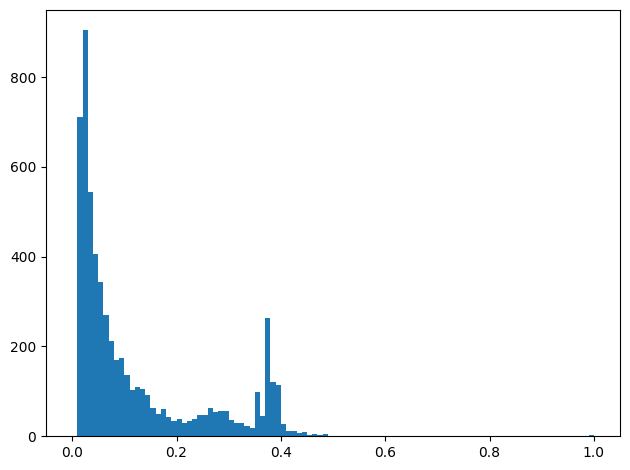

In [86]:
# counts, bins = np.histogram(relative_error)
# plt.stairs(counts, bins)
plt.hist(relative_error, bins=100)
plt.tight_layout()
plt.savefig(f'{PATH}/figs/histogram_error_{MODEL}_{VARIANT}_{ACC_THRESHOLD}acc.svg', format="svg"),
plt.show()

In [331]:
np.where((relative_error<=0.2))[0].shape

(4529,)

In [332]:
4529/5855

0.7735269000853972

In [330]:
np.where(accuracy_per_node <= 0.2)

(array([2966, 2971, 5850, 5851, 5852, 5853, 5854]),)

### Histogram of accuracy

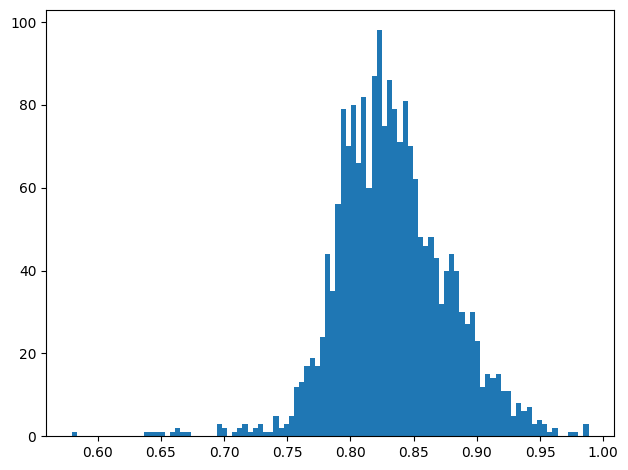

In [347]:
plt.hist(accuracy_per_scenario, bins=100)
plt.tight_layout()
# plt.savefig(f'{PATH}/figs/histogram_acc_{MODEL}_{VARIANT}_{ACC_THRESHOLD}acc.svg', format="svg"),
plt.show()

In [355]:
np.where(accuracy_per_scenario<=0.65)[0]

array([ 684,  857, 1236, 1834])

In [334]:
4226/5855

0.7217762596071734

In [ ]:
accuracy_per_scenario[863]

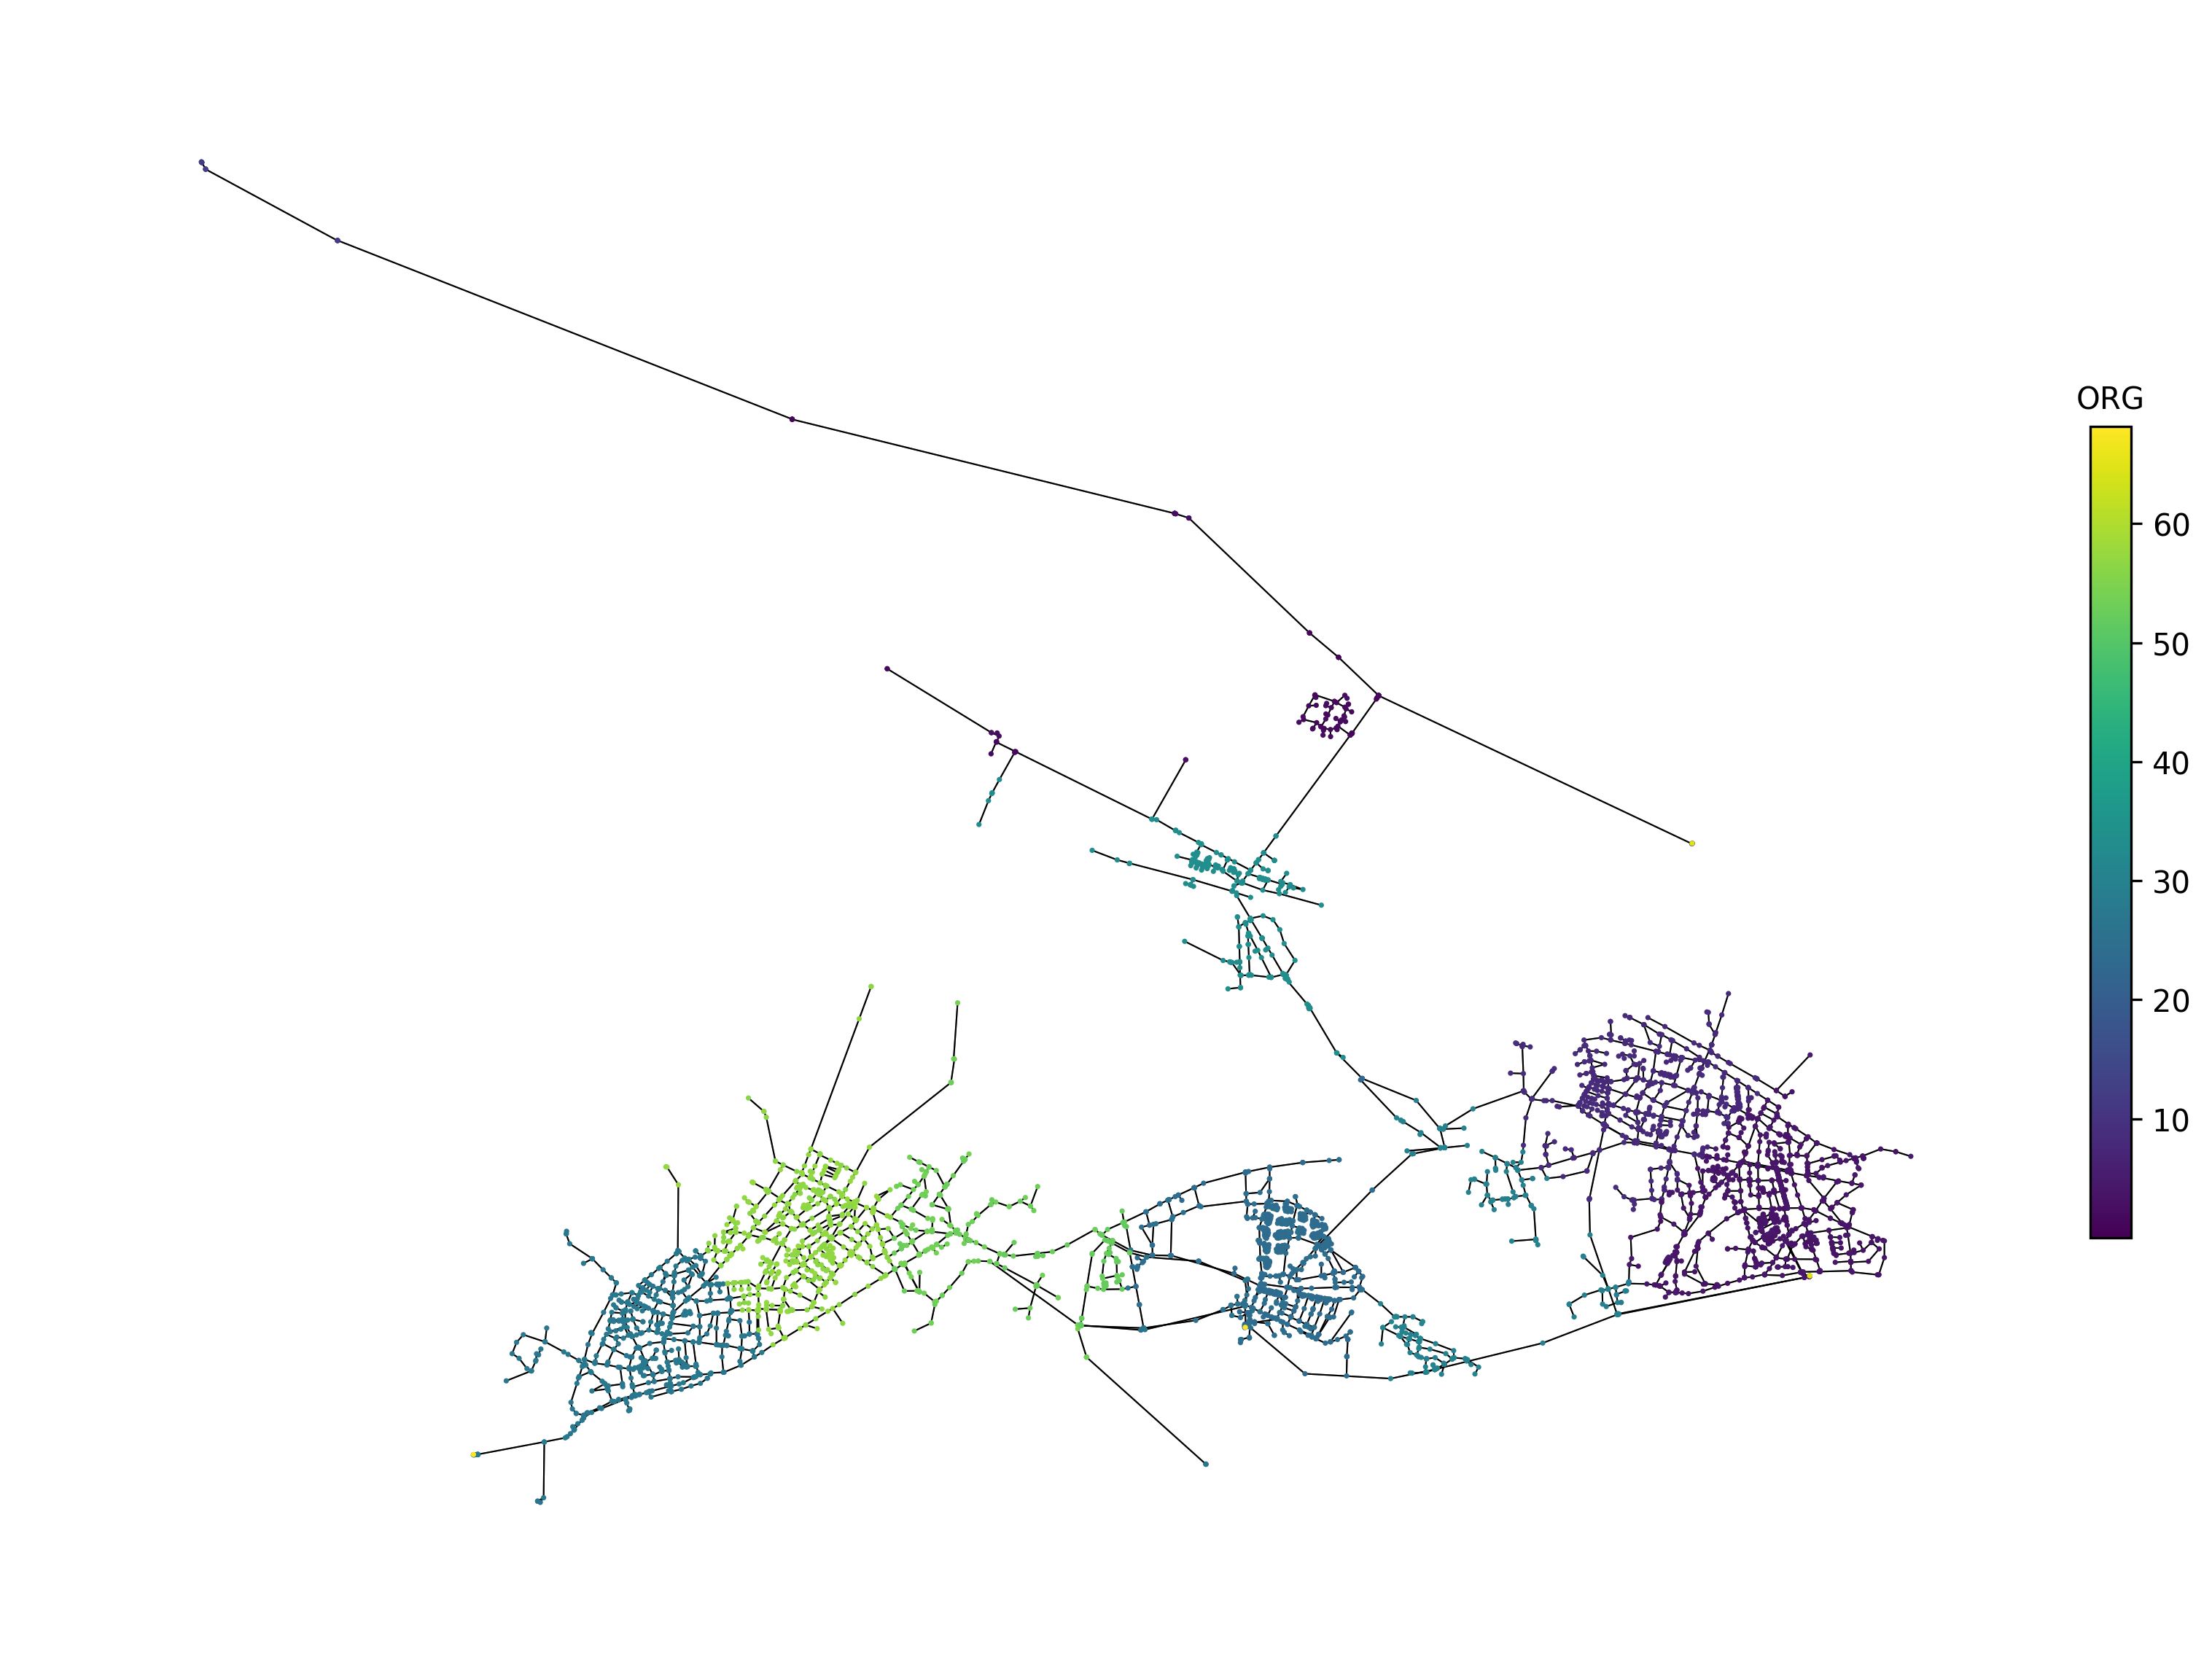

In [422]:
GRAPH_TYPE = "ORG"

wn = wntr.network.WaterNetworkModel(r'../GEN-09 Oosterbeek.inp')
filename = f'{PATH}/figs/MAP_{GRAPH_TYPE}_{MODEL}_{VARIANT}_{MASK_RATE}_{ACC_THRESHOLD}acc.svg'

if GRAPH_TYPE == "ACC":
    dataset = accuracy_per_node
    color_map = "RdYlGn"
elif GRAPH_TYPE == "REL_ERROR":
    dataset = relative_error
    color_map = "RdYlGn_r"
elif GRAPH_TYPE == "ORG":
    dataset = data[1834]     # [ 684,  857, 1236, 1834]
    color_map = "viridis"
    filename = None
    
for i, node in enumerate(wn.nodes()):
    node[1].elevation = dataset[i]

#     if str(node[1]) in ['381515', '541619', '541618', '381485', '381474', '381473', '674924', 
#                         '1851652', '674906', '675328']:
#         node[1].elevation = 0
#         print(f"{str(node[1])}-({i}): \t{dataset[i]}")
#     else:
#         node[1].elevation = 1

#     if dataset[i] >0.4 :
#         node[1].elevation = 1
# #         print(node[1])
#     else:
#         node[1].elevation = 0
    
    
#     if i>= 5850:
#         print(f"{i:04d}: {wn.node_name_list[i]}")
        

fig, ax = plt.subplots(figsize=(10, 7.5), dpi=300, layout='constrained')
ax = wntr.graphics.plot_network(wn, node_attribute='elevation',
                                node_size=3,
                                node_cmap=plt.colormaps[color_map],  # RdYlGn_r, viridis
                                node_colorbar_label=GRAPH_TYPE,
                                link_cmap=plt.colormaps['PiYG'],
                                link_width=0.5,
                                directed=False,
                                ax=ax,
                                filename=None
                               )

In [399]:
np.where(np.array(wn.node_name_list) == '373463')[0]

array([5431])

In [ ]:
dirs = {
    "best_training_model": f"../checkpoints/{MODEL}_best_training_{VARIANT}.pth",
}

checkpoint = checkpoint = torch.load(dirs["best_training_model"], map_location="cpu")
print(f'''
    best_epoch: {checkpoint['epoch']:03d}, 
    loss: {checkpoint['loss']:.10f}, 
    rel. error: {checkpoint['val_error']:.4f},
    accuracy: {checkpoint['val_acc']:.4f}
''')

In [ ]:
checkpoint["params"]

### Average pressure per node

In [338]:
root = zarr.open(store="../../datasets/10k_p_EPYNET_s_GEN-09 Oosterbeek_20230119.zip", mode='r')
val_data = np.array(root.pressure.valid)

mean = root.pressure.attrs['mean']
std = root.pressure.attrs['std']
min_val = root.pressure.attrs['min']
max_val = root.pressure.attrs['max']

# scaled = (val_data - min_val) / (max_val - min_val)
# avg_pressure = np.mean(scaled, axis=0)
avg_pressure = np.mean(val_data, axis=0)
print(f'''

min: {np.min(val_data)}, 
max: {np.max(val_data)}, 
mean: {np.mean(val_data)}, 
std: {np.std(val_data)}

''')



min: 9.999999998265139e-05, 
max: 90.70653633984497, 
mean: 46.748122288437415, 
std: 16.842623937007353




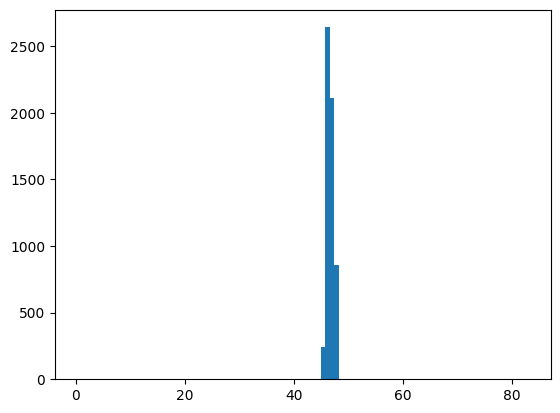

In [339]:
plt.hist(avg_pressure, bins=100)
plt.show()

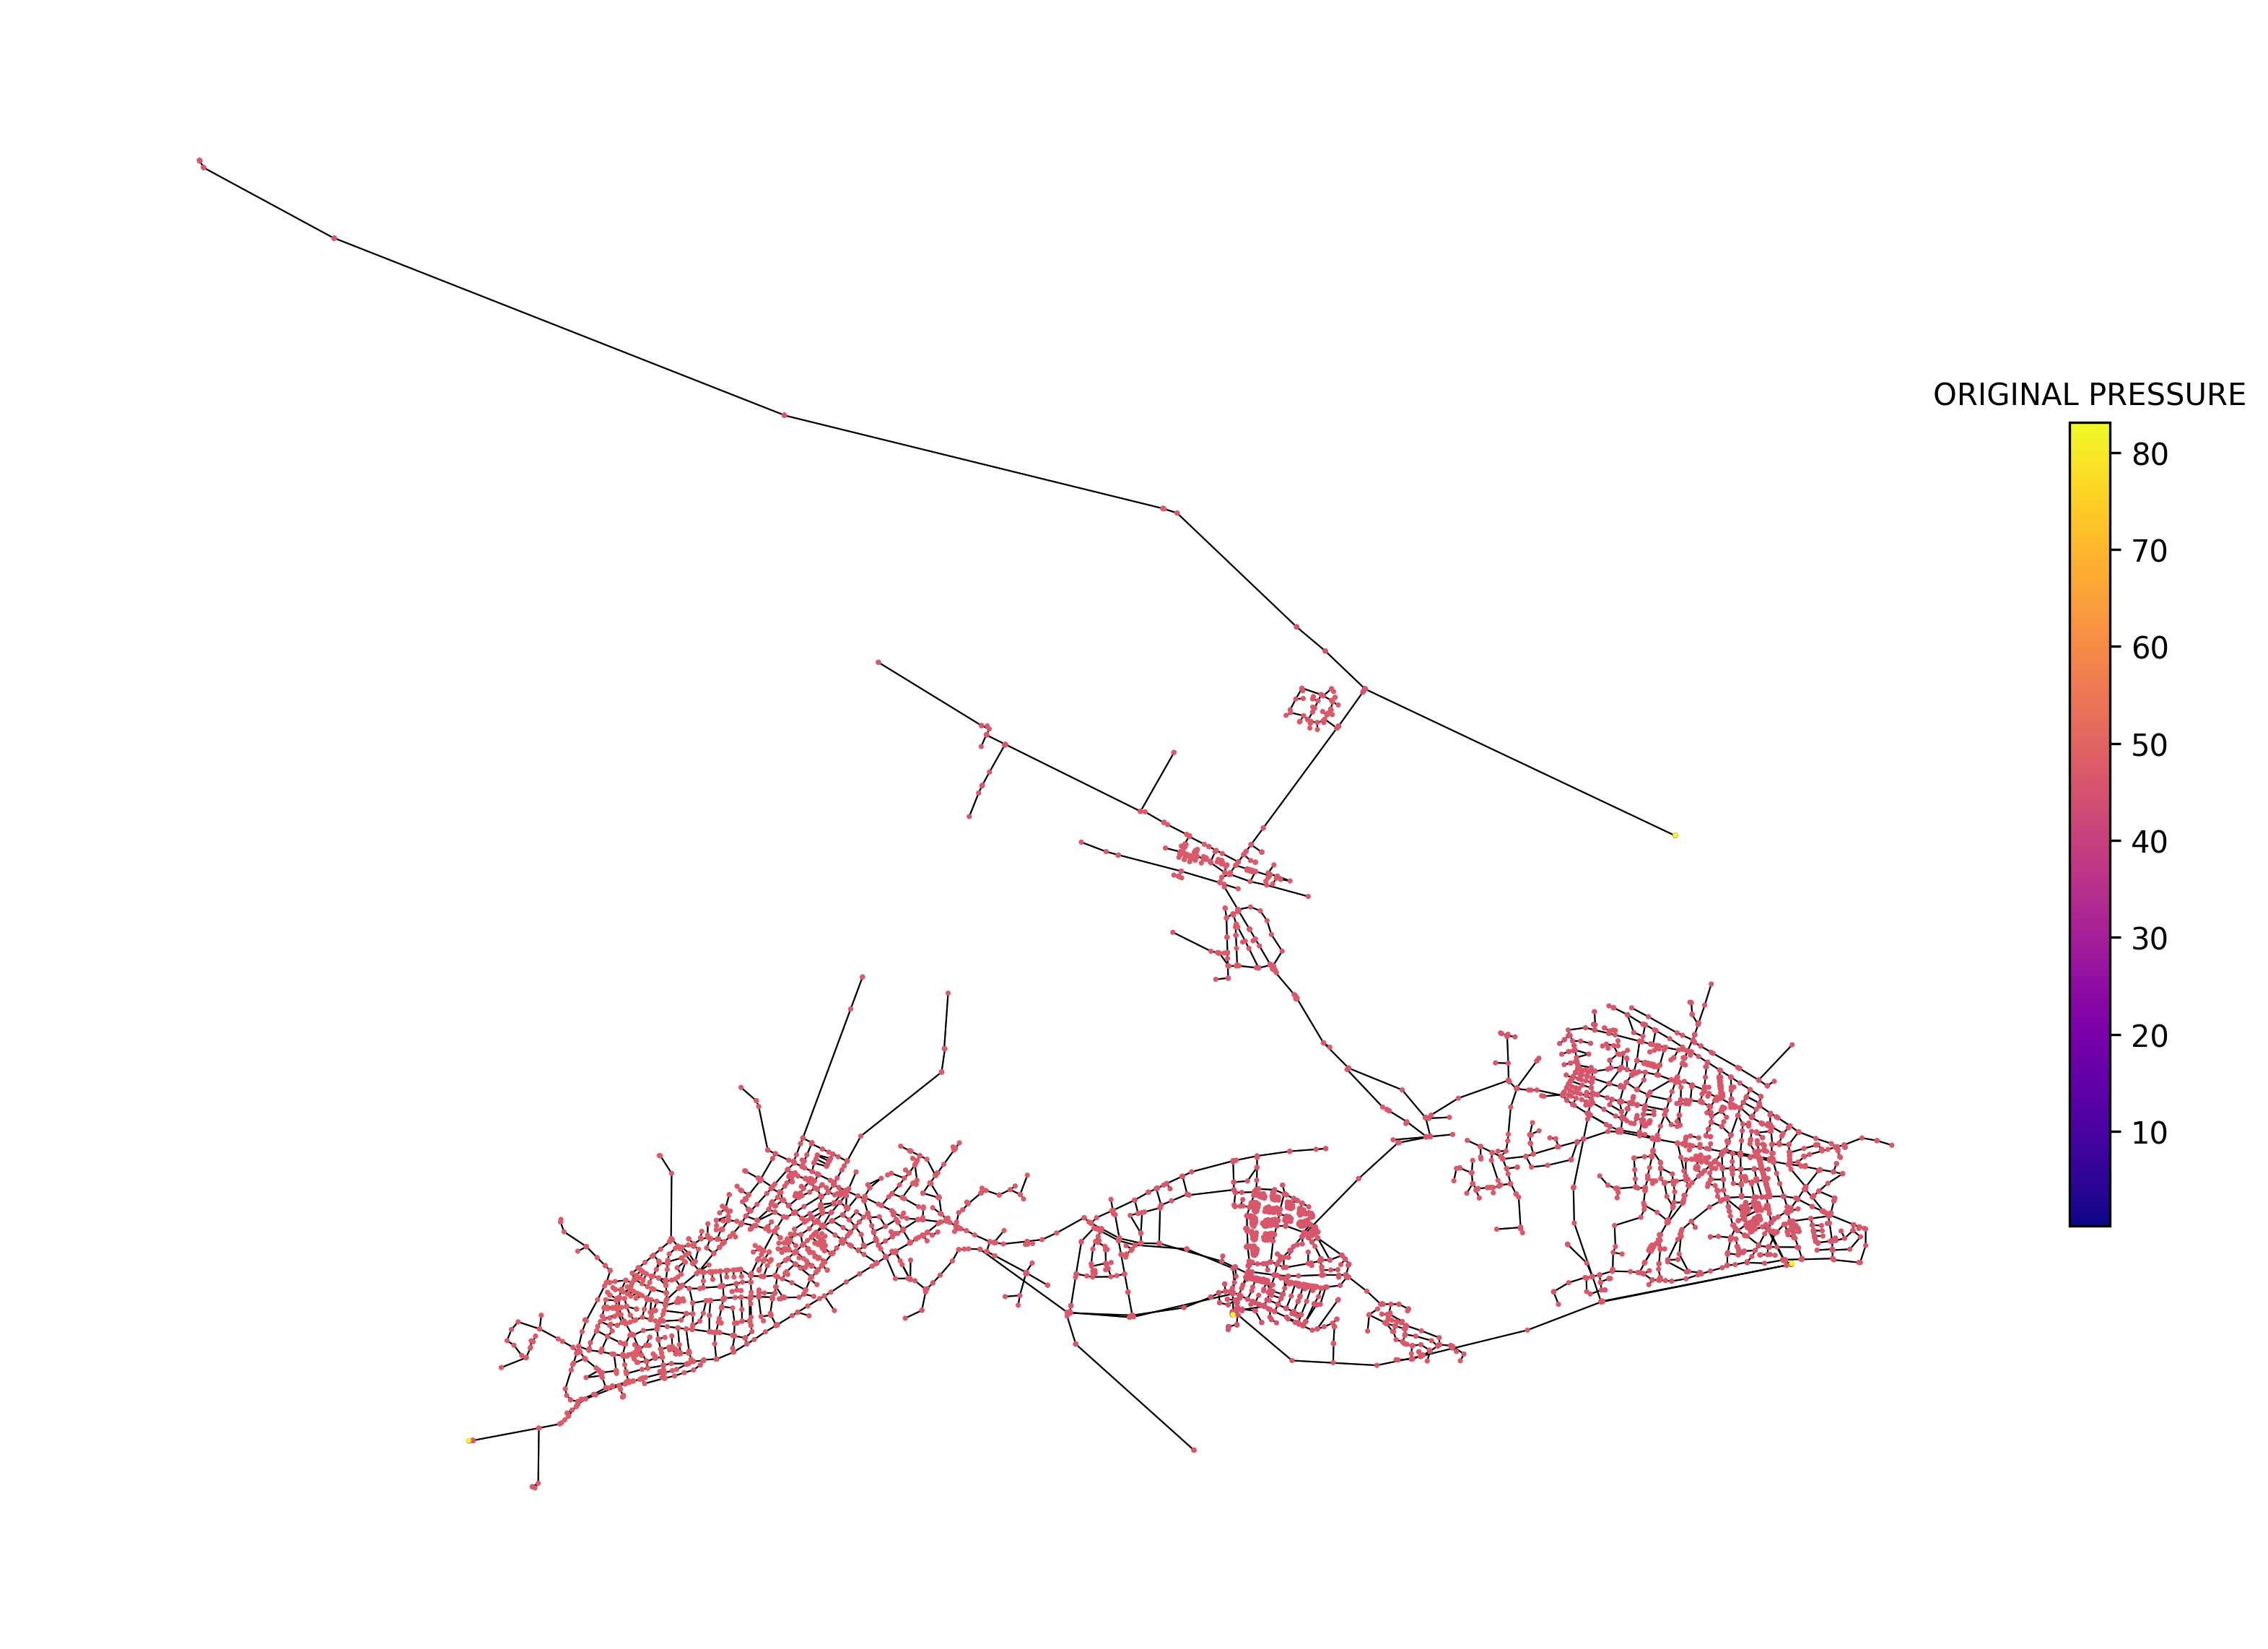

In [346]:
mean = np.mean(avg_pressure)
std = np.std(avg_pressure)
wn = wntr.network.WaterNetworkModel(r'../GEN-09 Oosterbeek.inp')
for i, node in enumerate(wn.nodes()):
    node[1].elevation = avg_pressure[i]
#     if avg_pressure[i] < 10:
#         node[1].elevation = 0
#     else:
#         node[1].elevation = 1
        
#     if mean - (1*std) <= avg_pressure[i] <= mean + (1*std):
#         node[1].elevation = 1
#     else:
#         node[1].elevation = 0        

# Nodes with pressure lower than 10
#     if avg_pressure[i] < 10:
#         print(f"{i:04d}: {wn.node_name_list[i]}")

# for i, valve in enumerate(wn.valves()):
#     if str(valve[1]) == "1048506_1.1048506_2.1":
#         print(valve)
    

# filename = f'../experiments_logs/figs/ERRORS_{MODEL}_{VARIANT}_{MASK_RATE}.svg'
# filename = f'../experiments_logs/figs/ERRORS_trained_all.svg'
    
fig, ax = plt.subplots(figsize=(10, 7.5), dpi=300, layout='constrained')
ax = wntr.graphics.plot_network(wn, node_attribute='elevation',
                                node_size=3,
                                node_cmap=plt.colormaps["plasma"],  # RdYlGn_r, viridis
                                node_colorbar_label="ORIGINAL PRESSURE",
                                link_cmap=plt.colormaps['PiYG'],
                                link_width=0.5,
                                directed=False,
                                ax=ax,
                               )